In [2]:
import numpy as np
import pandas as pd
import os
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

### Load Data

Load the dataset from 7 stations for all the period

In [3]:
data_dir = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/processed/I06AU_FULL'

# List to hold individual DataFrames from each CSV file
dataframes_list = []

# Iterate over each file in the folder
for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):  # Check if the file is a CSV
        file_path = os.path.join(data_dir, filename)
        # Read the CSV file and append the DataFrame to the list
        df = pd.read_csv(file_path)
        dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
all_data = pd.concat(dataframes_list, ignore_index=True)

In [4]:
print("Activity Data Description:\n", all_data.describe())

Activity Data Description:
               I06H1         I06H2         I06H3         I06H4         I06H5  \
count  2.215781e+07  2.215781e+07  2.215771e+07  2.215781e+07  3.755903e+06   
mean  -7.469854e-04  1.131288e-03  1.246250e-03  2.261474e-03  9.539551e-04   
std    1.381447e+02  1.646042e+02  2.364306e+02  1.947100e+02  1.165474e+02   
min   -4.885689e+03 -1.076065e+04 -8.201156e+03 -1.086238e+04 -2.770588e+03   
25%   -6.448519e+01 -7.309193e+01 -9.491635e+01 -8.258374e+01 -5.429896e+01   
50%    1.177604e-02  5.027863e-02 -2.997638e-02  1.820177e-03  3.225463e-02   
75%    6.458819e+01  7.320549e+01  9.487449e+01  8.261551e+01  5.428265e+01   
max    8.075200e+03  8.880485e+03  1.004973e+04  9.281826e+03  3.276452e+03   

              I06H6         I06H7         I06H8  
count  2.215781e+07  2.215781e+07  2.215781e+07  
mean  -5.309740e-04 -4.060426e-04 -1.876493e-04  
std    1.297622e+02  1.255001e+02  1.390275e+02  
min   -4.589272e+03 -4.177870e+03 -5.123077e+03  
25%   -6.0

In [6]:
df.drop('I06H5', axis=0, inplace=True)

KeyError: "['I06H5'] not found in axis"

In [27]:
# Creating a nested DataFrame
nested_df = pd.DataFrame()

for column in df.columns[1:]:  # Skipping the timestamp column
    nested_df[column] = df.groupby(df.columns[0])[column].apply(lambda x: x.reset_index(drop=True))

# Resulting nested_df will have each cell containing a pandas Series (a single time series)


In [28]:
# Extract features using TSFreshFeatureExtractor
extractor = TSFreshFeatureExtractor(default_fc_parameters="efficient", show_warnings=False)
X_features = extractor.fit_transform(nested_df)


In [37]:
num_features = extracted_features.shape[1]
print(f"Number of features extracted: {num_features}")

Number of features extracted: 5439


In [32]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)


In [33]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(X_scaled)

/home/viblab/anaconda3/envs/infrapy_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [34]:
# Apply Isolation Forest for Anomaly Detection
iso_forest = IsolationForest(random_state=0)
anomalies = iso_forest.fit_predict(X_scaled)


/home/viblab/anaconda3/envs/infrapy_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


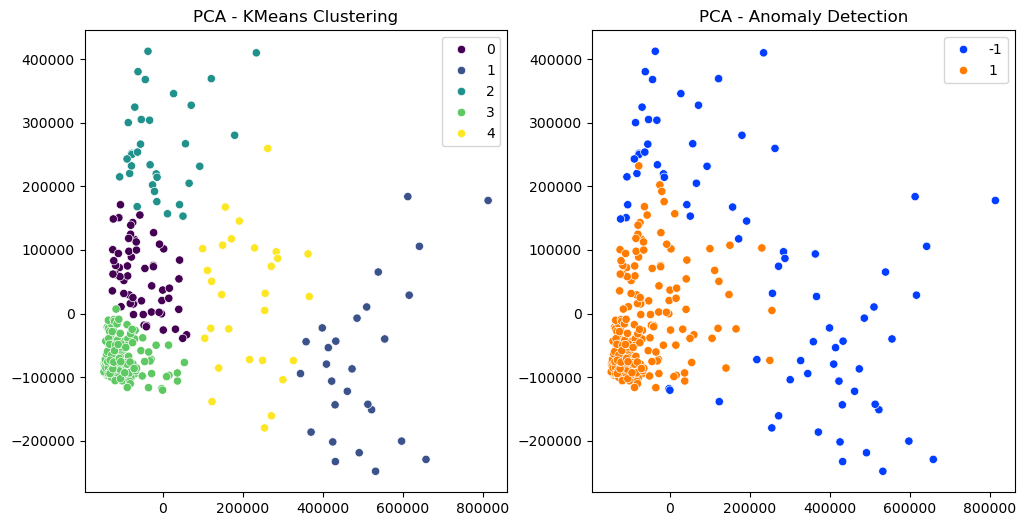

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)  # Adjust n_components as needed
X_pca = pca.fit_transform(extracted_features)

# Apply KMeans clustering on the reduced data
kmeans = KMeans(n_clusters=5, random_state=0)  # Adjust clusters as needed
clusters_pca = kmeans.fit_predict(X_pca)

# Apply Isolation Forest for Anomaly Detection on reduced data
iso_forest = IsolationForest(random_state=0)
anomalies_pca = iso_forest.fit_predict(X_pca)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_pca, palette='viridis')
plt.title('PCA - KMeans Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=anomalies_pca, palette='bright')
plt.title('PCA - Anomaly Detection')

plt.show()


In [40]:
kmeans_pca = KMeans(n_clusters=5, random_state=0)
clusters_pca = kmeans_pca.fit_predict(X_pca)

/home/viblab/anaconda3/envs/infrapy_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [41]:
# Reapply Isolation Forest for Anomaly Detection
iso_forest_pca = IsolationForest(random_state=0)
anomalies_pca = iso_forest_pca.fit_predict(X_pca)

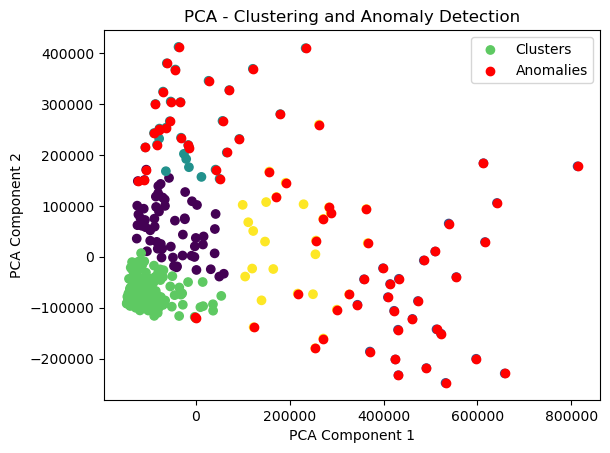

In [42]:
# Visualization (assuming 2D PCA for simplicity)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_pca, cmap='viridis', label='Clusters')
plt.scatter(X_pca[anomalies_pca == -1, 0], X_pca[anomalies_pca == -1, 1], color='red', label='Anomalies')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('PCA - Clustering and Anomaly Detection')
plt.show()

In [57]:
df.head()

,Unnamed: 0,I06H1,I06H2,I06H3,I06H4,I06H6,I06H7,I06H8
0,2018-12-24 11:22:06.100,-25.734253,0.866305,-397.305341,-43.262447,-88.930053,16.984659,-47.236816
1,2018-12-24 11:22:06.150,-75.169694,-71.124016,116.719686,-69.478001,-50.847307,12.748532,-20.436442
2,2018-12-24 11:22:06.200,-55.436031,-110.512348,393.301538,-30.716177,-4.432571,68.968803,41.622395
3,2018-12-24 11:22:06.250,-1.837271,-24.570833,107.598165,79.999223,16.570552,110.456728,82.702918
4,2018-12-24 11:22:06.300,-11.495444,86.689326,-344.735011,135.202447,13.322010,96.102665,71.729381


In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert date columns to datetime
all_data['Unnamed: 0'] = pd.to_datetime(all_data['Unnamed: 0'])
start_date = pd.to_datetime('2018-12-24 11:22:06.100')
end_date = pd.to_datetime('2018-12-24 11:22:06.300')

# Filter the DataFrame for the selected date range and station
station_column = 'I06H1'  # Replace with your actual station column name
mask = (all_data['Unnamed: 0'] >= start_date) & (all_data['Unnamed: 0'] <= end_date)
selected_station_data = all_data.loc[mask, [station_column, 'Unnamed: 0']].set_index('Unnamed: 0')

# Check if data is present
if selected_station_data.empty:
    raise ValueError("No data available in the specified date range.")

# Prepare clusters and anomalies for plotting (assuming they are numpy arrays)
selected_clusters = clusters[mask]
selected_anomalies = anomalies[mask]

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(selected_station_data.index, selected_station_data[station_column], label='Time Series', lw=1)

# Highlight clusters
for cluster_label in np.unique(selected_clusters):
    cluster_points = selected_station_data.index[selected_clusters == cluster_label]
    plt.scatter(cluster_points, selected_station_data.loc[cluster_points, station_column], 
                label=f'Cluster {cluster_label}', alpha=0.6, edgecolor='w', s=50)

# Highlight anomalies
anomaly_points = selected_station_data.index[selected_anomalies == -1]
plt.scatter(anomaly_points, selected_station_data.loc[anomaly_points, station_column], 
            color='red', label='Anomalies', zorder=5, alpha=0.8, edgecolor='k', s=50)

plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'Time Series for {station_column} with Clusters and Anomalies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ValueError: No data available in the specified date range.

In [70]:
# Convert the date column to datetime if it's not already
all_data['Unnamed: 0'] = pd.to_datetime(all_data['Unnamed: 0'])

# Check the earliest and latest dates in the DataFrame
earliest_date = all_data['Unnamed: 0'].min()
latest_date = all_data['Unnamed: 0'].max()

print(f"Earliest date in the DataFrame: {earliest_date}")
print(f"Latest date in the DataFrame: {latest_date}")


Earliest date in the DataFrame: NaT
Latest date in the DataFrame: NaT


In [71]:
import pandas as pd

# Assuming 'all_data' is your DataFrame
# First, let's try converting the 'Unnamed: 0' column to datetime with error handling

# Attempt to convert the 'Unnamed: 0' column to datetime format, handling errors
all_data['Unnamed: 0'] = pd.to_datetime(all_data['Unnamed: 0'], errors='coerce')

# Now, check the earliest and latest dates again
earliest_date = all_data['Unnamed: 0'].min()
latest_date = all_data['Unnamed: 0'].max()

print(f"Earliest date in the DataFrame after conversion: {earliest_date}")
print(f"Latest date in the DataFrame after conversion: {latest_date}")

# If the conversion is successful, you can proceed with filtering the data
# Make sure the dates in 'start_date' and 'end_date' are within this range
start_date = '2018-12-24 11:22:06.100'
end_date = '2018-12-24 11:22:06.300'
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame for the selected date range and station
station_column = 'I06H1'  # Replace with your actual station column name
selected_data = all_data[(all_data['Unnamed: 0'] >= start_date) & (all_data['Unnamed: 0'] <= end_date)]

# Check if the selected_data is empty
if selected_data.empty:
    raise ValueError("No data in the selected date range.")

# Proceed with the rest of your analysis and plotting...


Earliest date in the DataFrame after conversion: NaT
Latest date in the DataFrame after conversion: NaT


ValueError: No data in the selected date range.